In [ ]:
!pip install tensorflow
!pip install imblearn
!pip install keras-tuner --upgrade

In [46]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import tensorflow as tf
from imblearn.combine import SMOTETomek
from keras.layers import Dense, Activation,InputLayer,Dropout
from tensorflow.keras.optimizers import SGD 

Preprocessing

In [11]:

cl_names=["sequence name","mcg","gvh","lip","chg","aac","alm1","alm2","classes"]

#read ans split data set based on white spaces..and..give the columns name
df=pd.read_csv("ecoli.data",delim_whitespace=True,names=cl_names )

#a dataframe filtered based on  two classes "cp" and "im"

kl_series=(df['classes'] == ('cp') ) | (df['classes'] == ('im'))

filtered_df=df.loc[kl_series]

#numerical representation of the classes
filtered_df=filtered_df.replace(to_replace={"cp":0,"im":1})

# Remove column name 'A'
filtered_df=filtered_df.drop(['sequence name'], axis = 1)

filtered_df

,mcg,gvh,lip,chg,aac,alm1,alm2,classes
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,0
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,0
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,0
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,0
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,0
...,...,...,...,...,...,...,...,...
215,0.10,0.49,0.48,0.5,0.41,0.67,0.21,1
216,0.30,0.51,0.48,0.5,0.42,0.61,0.34,1
217,0.61,0.47,0.48,0.5,0.00,0.80,0.32,1
218,0.63,0.75,0.48,0.5,0.64,0.73,0.66,1


In [12]:
filtered_df.describe()

,mcg,gvh,lip,chg,aac,alm1,alm2,classes
count,220.000000,220.000000,220.000000,220.0,220.000000,220.000000,220.000000,220.000000
mean,0.403773,0.440136,0.482364,0.5,0.483045,0.468364,0.512545,0.350000
std,0.161516,0.098173,0.035058,0.0,0.105143,0.235186,0.203211,0.478057
min,0.000000,0.160000,0.480000,0.5,0.000000,0.030000,0.000000,0.000000
25%,0.290000,0.370000,0.480000,0.5,0.420000,0.280000,0.367500,0.000000
50%,0.400000,0.440000,0.480000,0.5,0.480000,0.375000,0.440000,0.000000
75%,0.510000,0.502500,0.480000,0.5,0.552500,0.710000,0.710000,1.000000
max,0.890000,0.760000,1.000000,0.5,0.740000,1.000000,0.990000,1.000000


In [90]:
#Dealing with imbalanced data

cp=filtered_df[filtered_df["classes"]==0]
im=filtered_df[filtered_df["classes"]==1]
print(f"the total nr. samples with im class: {len(im)} vs. data with cp: {len(cp)}")

# splitting data to to x and y
X = filtered_df.iloc[:, 0:-1] # or #X=filtered_df.loc[:, filtered_df.columns != 'classes']
y = filtered_df["classes"]

#reshaping the data to balance it via up- and undersampling
smt = SMOTETomek(random_state=42)
X_res, y_res=smt.fit_resample(X,y)
print(f"After reshaping the total nr. samples with im class: {len(X_res)} vs. data with cp: {len(cp)}")


the total nr. samples with im class: 77 vs. data with cp: 143
After reshaping the total nr. samples with im class: 282 vs. data with cp: 143


In [ ]:
#splitting data into train and test
x_train,x_test, y_train, y_test = train_test_split(X_res, y_res, shuffle=True, test_size=0.2)

Network architecture: appraoch 1

In [113]:

nn = tf.keras.models.Sequential()  #MLP/feedforward nn
nn.add( InputLayer(input_shape=x_train.shape[1]) )
nn.add(tf.keras.layers.Dense(9,activation='relu'))
nn.add(tf.keras.layers.Dense(1,activation='sigmoid'))  #softmax because output just propobality destribution

#sorchastic gradient decent
sgd_opt=SGD(learning_rate=0.3)

nn.compile(loss='mean_squared_error',optimizer=sgd_opt, metrics=["accuracy"])



#print(nn.summary())
#Via trail and error, found out that around 14 epoch is perfect for this data. 
#The lower epochs and less complexity the more realiable model is.
#This is why we choose to have 10 epoch and just one hidden layer
fitting_stage=nn.fit( x_train,y_train, epochs=14, validation_data=(x_test,y_test)) #20 epochs is perfect in for this data set


Epoch 1/14
8/8 [==============================] - 0s 20ms/step - loss: 0.2293 - accuracy: 0.5822 - val_loss: 0.2119 - val_accuracy: 0.9474
Epoch 2/14
8/8 [==============================] - 0s 5ms/step - loss: 0.2073 - accuracy: 0.9111 - val_loss: 0.2132 - val_accuracy: 0.5088
Epoch 3/14
8/8 [==============================] - 0s 5ms/step - loss: 0.1961 - accuracy: 0.7244 - val_loss: 0.1843 - val_accuracy: 0.9474
Epoch 4/14
8/8 [==============================] - 0s 5ms/step - loss: 0.1826 - accuracy: 0.9244 - val_loss: 0.1810 - val_accuracy: 0.6842
Epoch 5/14
8/8 [==============================] - 0s 5ms/step - loss: 0.1687 - accuracy: 0.8889 - val_loss: 0.1756 - val_accuracy: 0.6667
Epoch 6/14
8/8 [==============================] - 0s 5ms/step - loss: 0.1567 - accuracy: 0.8622 - val_loss: 0.1610 - val_accuracy: 0.7018
Epoch 7/14
8/8 [==============================] - 0s 5ms/step - loss: 0.1428 - accuracy: 0.9156 - val_loss: 0.1295 - val_accuracy: 0.9474
Epoch 8/14
8/8 [=================

In [114]:
predicted=nn.predict(x_test)

pre=[ 1  if predicted[i][0]>0.5 else 0 for i in range(len(predicted)) ]

correct=0
differance= np.equal(y_test,pre)

for val in differance:
    if val==True:
        correct+=1
       
test_loss,accuracy =nn.evaluate(x_test,y_test)

print(f"Nr. correct predictions is: {correct} out of {len(pre)} samples.In other words, \
the test accuracy is {str(accuracy)[:4]}% and test_loss is {str(test_loss)[:4]}%.")


2/2 [==============================] - 0s 2ms/step - loss: 0.0604 - accuracy: 0.9825
Nr. correct predictions is: 56 out of 57 samples.In other words, the test accuracy is 0.98% and test_loss is 0.06%.


Plotting loss and accuracy

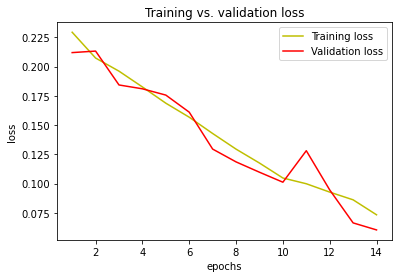

In [115]:

#plot the training and validation accuracy and loss at each epoch
loss = fitting_stage.history['loss']
val_loss = fitting_stage.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training vs. validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

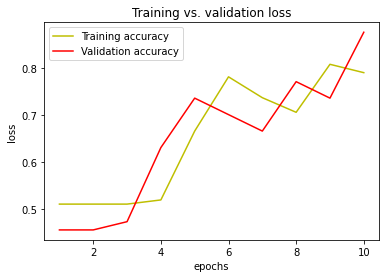

In [110]:
#plot the training and validation accuracy and loss at each epoch
acc = fitting_stage.history['accuracy']
val_acc = fitting_stage.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training vs. validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Network architecture: appraoch 2

In [103]:

nn = tf.keras.models.Sequential()  #MLP/feedforward nn
nn.add( InputLayer(input_shape=x_train.shape[1]) )
nn.add(tf.keras.layers.Dense(9,activation='relu'))
nn.add(tf.keras.layers.Dense(1,activation='sigmoid'))  

nn.compile(loss='binary_crossentropy',optimizer='adam', metrics=["accuracy"])

fitting_stage2=nn.fit( x_train,y_train, epochs=87, validation_data=(x_test,y_test)) 


Epoch 1/87
8/8 [==============================] - 0s 21ms/step - loss: 0.6864 - accuracy: 0.5022 - val_loss: 0.6852 - val_accuracy: 0.4737
Epoch 2/87
8/8 [==============================] - 0s 5ms/step - loss: 0.6803 - accuracy: 0.5156 - val_loss: 0.6810 - val_accuracy: 0.4912
Epoch 3/87
8/8 [==============================] - 0s 5ms/step - loss: 0.6761 - accuracy: 0.5244 - val_loss: 0.6767 - val_accuracy: 0.4912
Epoch 4/87
8/8 [==============================] - 0s 5ms/step - loss: 0.6722 - accuracy: 0.5333 - val_loss: 0.6734 - val_accuracy: 0.4912
Epoch 5/87
8/8 [==============================] - 0s 4ms/step - loss: 0.6680 - accuracy: 0.5378 - val_loss: 0.6691 - val_accuracy: 0.5088
Epoch 6/87
8/8 [==============================] - 0s 5ms/step - loss: 0.6643 - accuracy: 0.5378 - val_loss: 0.6653 - val_accuracy: 0.5088
Epoch 7/87
8/8 [==============================] - 0s 5ms/step - loss: 0.6609 - accuracy: 0.5511 - val_loss: 0.6605 - val_accuracy: 0.5614
Epoch 8/87
8/8 [=================

Epoch 60/87
8/8 [==============================] - 0s 5ms/step - loss: 0.4644 - accuracy: 0.9689 - val_loss: 0.4505 - val_accuracy: 0.9825
Epoch 61/87
8/8 [==============================] - 0s 5ms/step - loss: 0.4597 - accuracy: 0.9689 - val_loss: 0.4484 - val_accuracy: 0.9649
Epoch 62/87
8/8 [==============================] - 0s 5ms/step - loss: 0.4565 - accuracy: 0.9556 - val_loss: 0.4482 - val_accuracy: 0.9474
Epoch 63/87
8/8 [==============================] - 0s 5ms/step - loss: 0.4546 - accuracy: 0.9511 - val_loss: 0.4475 - val_accuracy: 0.9298
Epoch 64/87
8/8 [==============================] - 0s 5ms/step - loss: 0.4505 - accuracy: 0.9511 - val_loss: 0.4416 - val_accuracy: 0.9474
Epoch 65/87
8/8 [==============================] - 0s 4ms/step - loss: 0.4464 - accuracy: 0.9556 - val_loss: 0.4341 - val_accuracy: 0.9649
Epoch 66/87
8/8 [==============================] - 0s 5ms/step - loss: 0.4421 - accuracy: 0.9689 - val_loss: 0.4283 - val_accuracy: 0.9649
Epoch 67/87
8/8 [==========

In [104]:
predicted2=nn.predict(x_test)

pre2=[ 1  if predicted2[i][0]>0.5 else 0 for i in range(len(predicted2)) ]

correct2=0
differance2= np.equal(y_test,pre2)

for val in differance2:
    if val==True:
        correct2+=1
       
test_loss2,accuracy2 =nn.evaluate(x_test,y_test)

print(f"Nr. correct predictions is: {correct2} out of {len(pre2)} samples.In other words, \
the test accuracy is {str(accuracy2)[:4]}% and test_loss is {str(test_loss2)[:4]}%.")


2/2 [==============================] - 0s 3ms/step - loss: 0.3529 - accuracy: 0.9649
Nr. correct predictions is: 55 out of 57 samples.In other words, the test accuracy is 0.96% and test_loss is 0.35%.


In [113]:
test_loss,accuracy =nn.evaluate(x_test,y_test)
accuracy

2/2 [==============================] - 0s 3ms/step - loss: 0.3467 - accuracy: 1.0000


1.0

In [ ]:
"""
network archtiecture/ Parameter tuning


"""

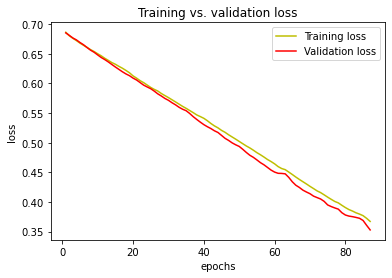

In [106]:
#plot the training and validation accuracy and loss at each epoch
loss = fitting_stage2.history['loss']
val_loss = fitting_stage2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training vs. validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

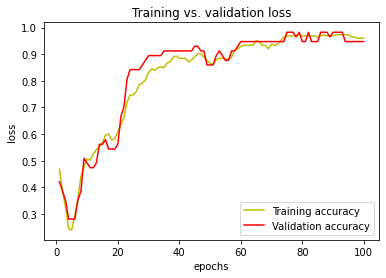

In [82]:
#plot the training and validation accuracy and loss at each epoch
acc = fitting_stage2.history['accuracy']
val_acc = fitting_stage2.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training vs. validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()